In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
fld = r"D:\Storage\datasets\first-break-recognition-dataset\data\"
file_name = r"Halfmile3D_add_geom_sorted.hdf5"
f = dict(h5py.File(os.path.join(fld, file_name)["TRACE_DATA/DEFAULT"])

In [3]:
def get_rec_ids() -> tuple[npt.NDArray[np.int_], npt.NDArray[np.int_], int]:
    rec = np.c_[f["REC_X"][:], f["REC_Y"][:]]
    unique_recs = np.unique(rec, axis=0)
    match_x = np.abs(rec[:, 0][:, None] - unique_recs[:, 0][None, :]) == 0
    match_y = np.abs(rec[:, 1][:, None] - unique_recs[:, 1][None, :]) == 0
    return rec, np.nonzero(np.logical_and(match_x, match_y))[1], len(unique_recs)


rec, rec_ids, n_unique_recs = get_rec_ids()

In [4]:
def prepare_data_array(receiver_ids: npt.NDArray[np.int_], n_unique_receivers: int) -> list[npt.NDArray[np.float_]]:
    data_array = f["data_array"][:]
    result = []
    for i in tqdm(range(n_unique_receivers)):
        result.append(data_array[receiver_ids == i, :])
    return result

In [5]:
def prepare_shot_id(receiver_ids: npt.NDArray[np.int_], n_unique_receivers: int):
    result = []
    for i in tqdm(range(n_unique_receivers)):
        result.append(f["SHOTID"][:][receiver_ids == i, :].flatten())
    return result

In [6]:
def prepare_sample_rate(receiver_ids: npt.NDArray[np.int_], n_unique_receivers: int):
    result = []
    for i in tqdm(range(n_unique_receivers)):
        result.append(f["SAMP_RATE"][:][receiver_ids == i, :].flatten()[0])
    return result

In [7]:
def prepare_spare1(receiver_ids: npt.NDArray[np.int_], n_unique_receivers: int):
    result = []
    for i in tqdm(range(n_unique_receivers)):
        result.append(f["SPARE1"][:][receiver_ids == i, :].flatten())
    return result

In [8]:
df = pd.DataFrame(
    {
        "data_array": prepare_data_array(rec_ids, n_unique_recs),
        "rec_coord": [rec[np.where(rec_ids==i)[0][0], :] for i in range(n_unique_recs)],
        "shot_id": prepare_shot_id(rec_ids, n_unique_recs),
        "sample_rate": prepare_sample_rate(rec_ids, n_unique_recs),
        "spare1": prepare_spare1(rec_ids, n_unique_recs),
    }
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2378/2378 [00:15<00:00, 152.28it/s]


In [9]:
df.head()

,data_array,rec_coord,shot_id,sample_rate,spare1
0,"[[0.0009000493, -0.0020033163, -0.0030377163, ...","[698463, 5245981]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[652, -1, 640, -1, 624, 608, 598, 594, 590, 58..."
1,"[[0.0003662742, 0.0010195031, 0.00094688666, 0...","[698477, 5245968]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[650, -1, 640, -1, 620, 604, 595, 590, 586, 57..."
2,"[[0.0029259485, 0.0032523582, 0.0032163851, 0....","[698491, 5245953]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[650, -1, 638, -1, 618, 604, 592, 590, 584, 57..."
3,"[[-0.0004475608, 0.0011310767, 0.0012399429, 0...","[698505, 5245939]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[648, -1, 632, -1, 612, 600, 589, 584, 580, 57..."
4,"[[-0.003561061, -0.0037425568, -0.0016920356, ...","[698520, 5245925]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[656, -1, 632, -1, 612, 598, 586, 584, 578, 57..."


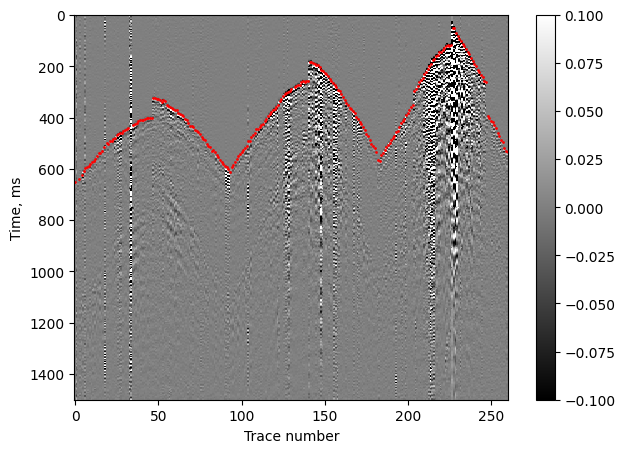

In [10]:
i = 0
x = np.arange(df["data_array"][i].T.shape[1], dtype=int)
y = 1e-3 * np.arange(df["data_array"][i].T.shape[0]) * df["sample_rate"][i]
X, Y = np.meshgrid(x, y)
spare1 = df["spare1"][i]
eps = 1e-6

plt.figure(figsize=(7, 5))
plt.pcolor(X, Y, df["data_array"][i].T, cmap="gray", clim=(-0.1, 0.1))
plt.plot(x[spare1 > eps], spare1[spare1 > eps], ".r", ms=2)
plt.gca().invert_yaxis()
plt.ylabel("Time, ms")
plt.xlabel("Trace number")
plt.colorbar()
plt.show()

In [11]:
df["data_array_shape"] = df["data_array"].apply(lambda x: x.shape)
df["data_array"] = df["data_array"].apply(lambda x: x.flatten())
df.to_parquet(os.path.join(fld, "df.parquet.gzip"), compression="gzip")